# Simple Football Analyst

## Initialization

In [1]:
#import the needed lib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch
from mplsoccer.pitch import VerticalPitch
import seaborn as sns
import matplotlib.patheffects as pe
from scipy.ndimage import gaussian_filter

#import lib
from visualization import pitch

## Call and Clean Up The Data

In [2]:
#call the data using pandas

df = pd.read_csv('./data/player-analyst/england-usa.csv')
df.head()

,Team,Player,Event,Mins,Secs,X,Y,X2,Y2
0,England,19,Pass,0,5,50,52,29,58
1,England,5,Pass,0,7,26,66,26,34
2,England,6,Pass,0,10,26,22,26,60
3,England,5,Pass,0,10,30,51,25,33
4,England,6,Pass,0,10,23,29,22,53


In [3]:
df.describe()

,Player,Mins,Secs,X,Y,X2,Y2
count,316.000000,316.0,316.000000,316.000000,316.000000,316.000000,316.000000
mean,8.689873,0.0,10.936709,44.373418,46.981013,48.854430,46.598101
std,6.208445,0.0,0.439098,21.376440,25.593395,22.865605,26.378560
min,1.000000,0.0,5.000000,4.000000,3.000000,5.000000,1.000000
25%,4.000000,0.0,11.000000,27.000000,26.000000,30.000000,23.750000
50%,6.000000,0.0,11.000000,40.000000,50.000000,44.000000,48.000000
75%,12.000000,0.0,11.000000,60.250000,65.000000,67.250000,67.250000
max,22.000000,0.0,11.000000,96.000000,93.000000,99.000000,94.000000


In [4]:
#normalization the X and Y data. Because the data has 100 for each X and Y but the pitch is 120x80
df['X'] = df['X']*1.2
df['Y'] = df['Y']*0.8
df['X2'] = df['X2']*1.2
df['Y2'] = df['Y2']*0.8

## Make The Starting Line Up Dictionary 

Tracking player manually is exhausting. So I input their number as the player. So, you need to make the dictionary of player name 

In [5]:
player={1:"Pickford", 3:"Luke Shaw",4:"Declan Rice",5:"John Stones",6:"Harry Maguire",9:"Harry Kane",
        10:"Raheem Sterling",12:"Kieran Trippier",17:"Bukayo Saka",19:"Mason Mount",22:"Jude Bellingham"}

df["PlayerName"]=df["Player"].map(player)
df.iloc[:,[0,1,9,2,3,4,5,6,7,8]]

,Team,Player,PlayerName,Event,Mins,Secs,X,Y,X2,Y2
0,England,19,Mason Mount,Pass,0,5,60.0,41.6,34.8,46.4
1,England,5,John Stones,Pass,0,7,31.2,52.8,31.2,27.2
2,England,6,Harry Maguire,Pass,0,10,31.2,17.6,31.2,48.0
3,England,5,John Stones,Pass,0,10,36.0,40.8,30.0,26.4
4,England,6,Harry Maguire,Pass,0,10,27.6,23.2,26.4,42.4
...,...,...,...,...,...,...,...,...,...,...
311,England,5,John Stones,Pass,0,11,36.0,31.2,51.6,23.2
312,England,22,Jude Bellingham,Pass,0,11,63.6,21.6,75.6,8.8
313,England,3,Luke Shaw,Pass,0,11,76.8,12.0,84.0,23.2
314,England,10,Raheem Sterling,Pass,0,11,84.0,21.6,100.8,30.4


## Pass Web

In [6]:
#this is for maping pass web. We need passer and recipient
df["Passer"] = df["Player"]
df["PasserName"] = df["PlayerName"]
df["Recipient"] = df["Player"].shift(-1)
df["RecipientName"] = df["PlayerName"].shift(-1)

#create new dataframe which just contains pass data
passes = df[df["Event"]=="Pass"]
passes

,Team,Player,Event,Mins,Secs,X,Y,X2,Y2,PlayerName,Passer,PasserName,Recipient,RecipientName
0,England,19,Pass,0,5,60.0,41.6,34.8,46.4,Mason Mount,19,Mason Mount,5.0,John Stones
1,England,5,Pass,0,7,31.2,52.8,31.2,27.2,John Stones,5,John Stones,6.0,Harry Maguire
2,England,6,Pass,0,10,31.2,17.6,31.2,48.0,Harry Maguire,6,Harry Maguire,5.0,John Stones
3,England,5,Pass,0,10,36.0,40.8,30.0,26.4,John Stones,5,John Stones,6.0,Harry Maguire
4,England,6,Pass,0,10,27.6,23.2,26.4,42.4,Harry Maguire,6,Harry Maguire,5.0,John Stones
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,England,9,Pass,0,11,50.4,20.0,34.8,28.8,Harry Kane,9,Harry Kane,5.0,John Stones
311,England,5,Pass,0,11,36.0,31.2,51.6,23.2,John Stones,5,John Stones,22.0,Jude Bellingham
312,England,22,Pass,0,11,63.6,21.6,75.6,8.8,Jude Bellingham,22,Jude Bellingham,3.0,Luke Shaw
313,England,3,Pass,0,11,76.8,12.0,84.0,23.2,Luke Shaw,3,Luke Shaw,10.0,Raheem Sterling


In [7]:
passes["row_num"] = np.arange(len(passes))
passes["row_num"] = passes.reset_index().index
passes

/tmp/ipykernel_5158/3711632251.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes["row_num"] = np.arange(len(passes))
/tmp/ipykernel_5158/3711632251.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes["row_num"] = passes.reset_index().index


,Team,Player,Event,Mins,Secs,X,Y,X2,Y2,PlayerName,Passer,PasserName,Recipient,RecipientName,row_num
0,England,19,Pass,0,5,60.0,41.6,34.8,46.4,Mason Mount,19,Mason Mount,5.0,John Stones,0
1,England,5,Pass,0,7,31.2,52.8,31.2,27.2,John Stones,5,John Stones,6.0,Harry Maguire,1
2,England,6,Pass,0,10,31.2,17.6,31.2,48.0,Harry Maguire,6,Harry Maguire,5.0,John Stones,2
3,England,5,Pass,0,10,36.0,40.8,30.0,26.4,John Stones,5,John Stones,6.0,Harry Maguire,3
4,England,6,Pass,0,10,27.6,23.2,26.4,42.4,Harry Maguire,6,Harry Maguire,5.0,John Stones,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,England,9,Pass,0,11,50.4,20.0,34.8,28.8,Harry Kane,9,Harry Kane,5.0,John Stones,263
311,England,5,Pass,0,11,36.0,31.2,51.6,23.2,John Stones,5,John Stones,22.0,Jude Bellingham,264
312,England,22,Pass,0,11,63.6,21.6,75.6,8.8,Jude Bellingham,22,Jude Bellingham,3.0,Luke Shaw,265
313,England,3,Pass,0,11,76.8,12.0,84.0,23.2,Luke Shaw,3,Luke Shaw,10.0,Raheem Sterling,266


In [8]:
passes.dtypes

Team              object
Player             int64
Event             object
Mins               int64
Secs               int64
X                float64
Y                float64
X2               float64
Y2               float64
PlayerName        object
Passer             int64
PasserName        object
Recipient        float64
RecipientName     object
row_num            int64
dtype: object

In [9]:
#we need to change the recipient as int
passes = passes.astype({"Recipient":"int"})
passes.dtypes

Team              object
Player             int64
Event             object
Mins               int64
Secs               int64
X                float64
Y                float64
X2               float64
Y2               float64
PlayerName        object
Passer             int64
PasserName        object
Recipient          int64
RecipientName     object
row_num            int64
dtype: object

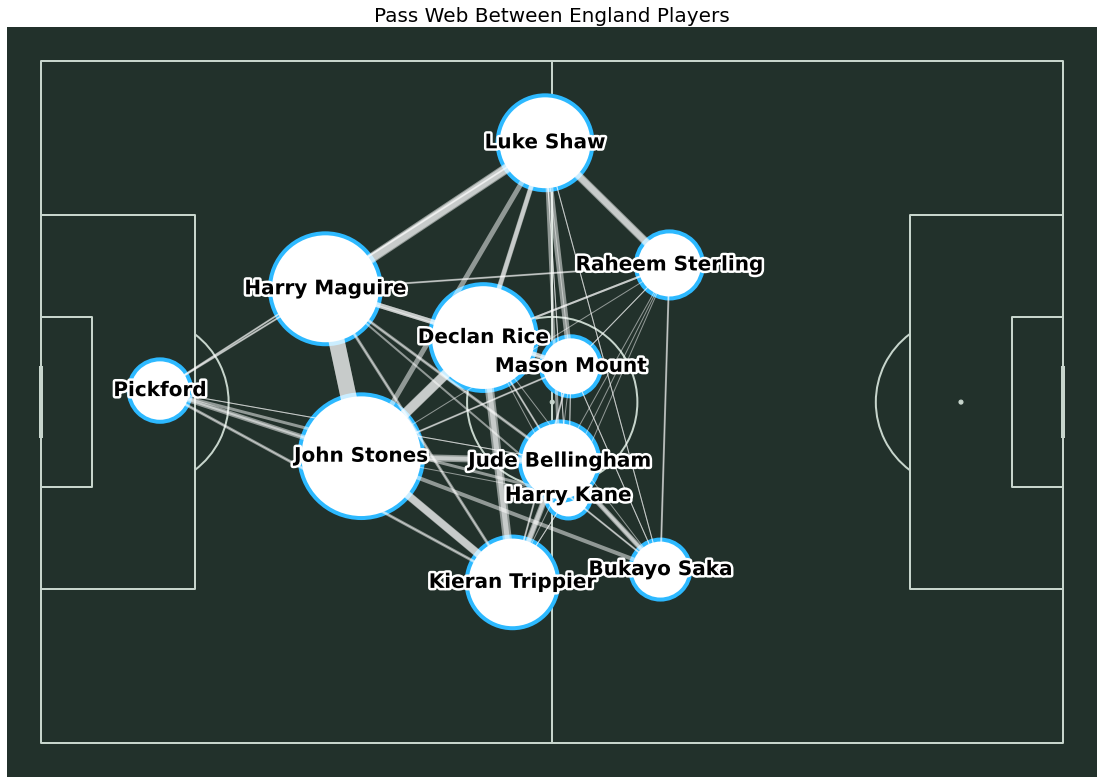

In [10]:
pitch.passweb(passes)

## Passmap and Heatmap

### Harry Maguire

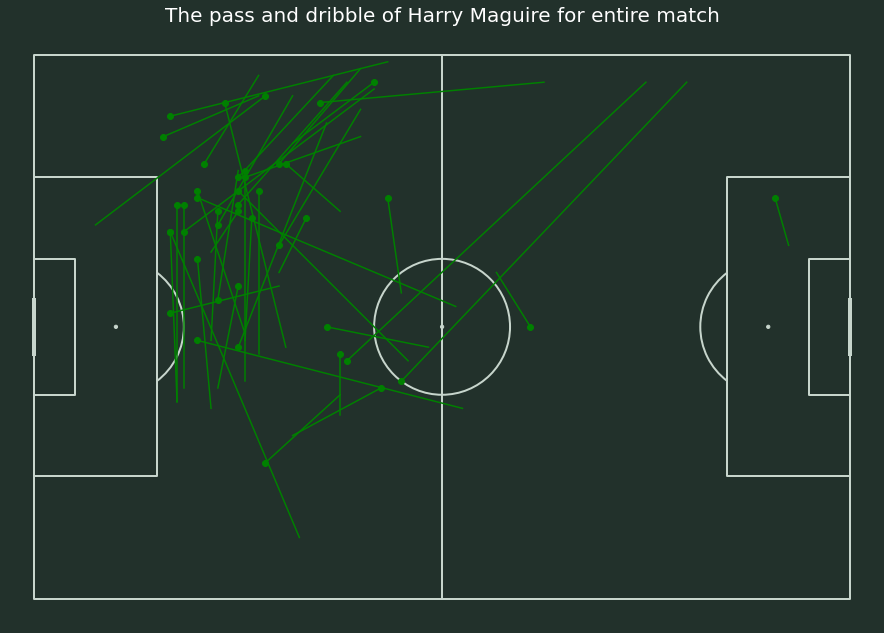

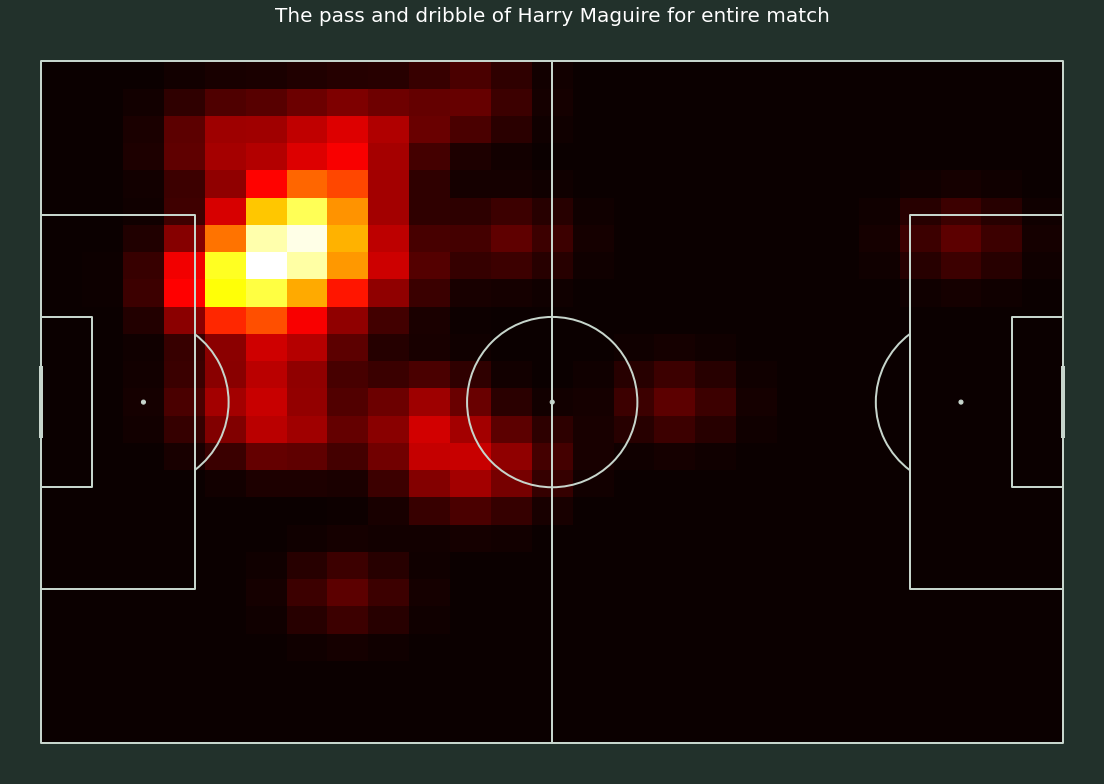

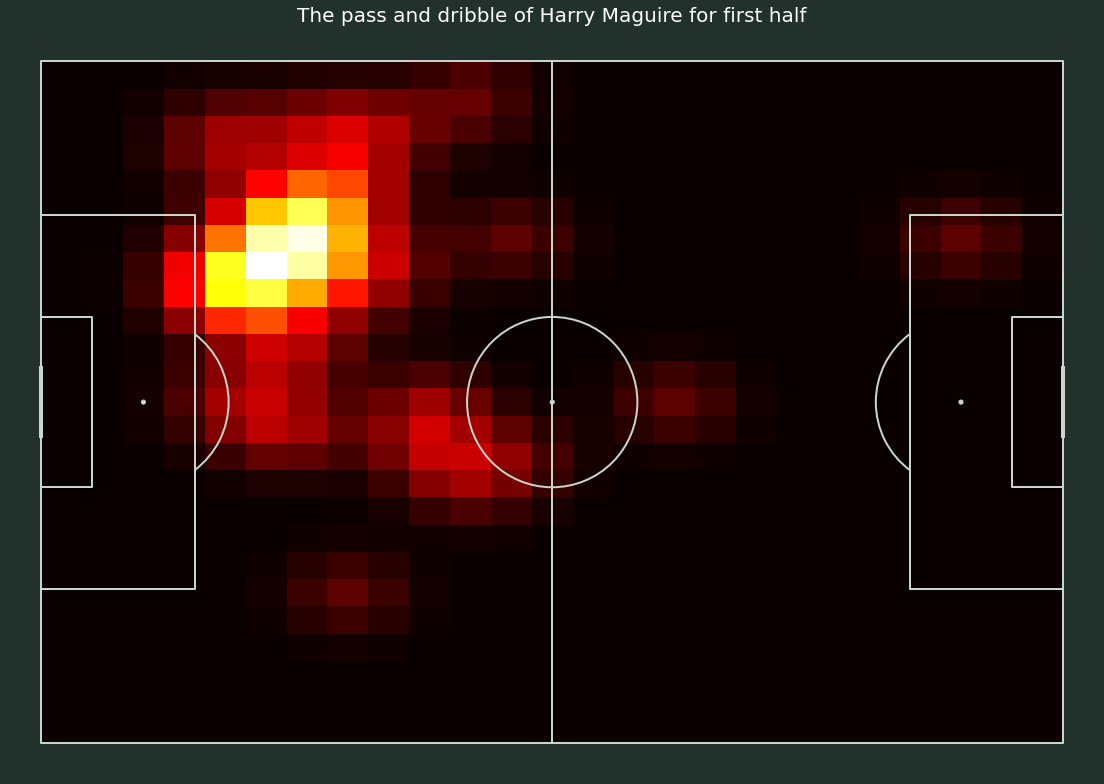

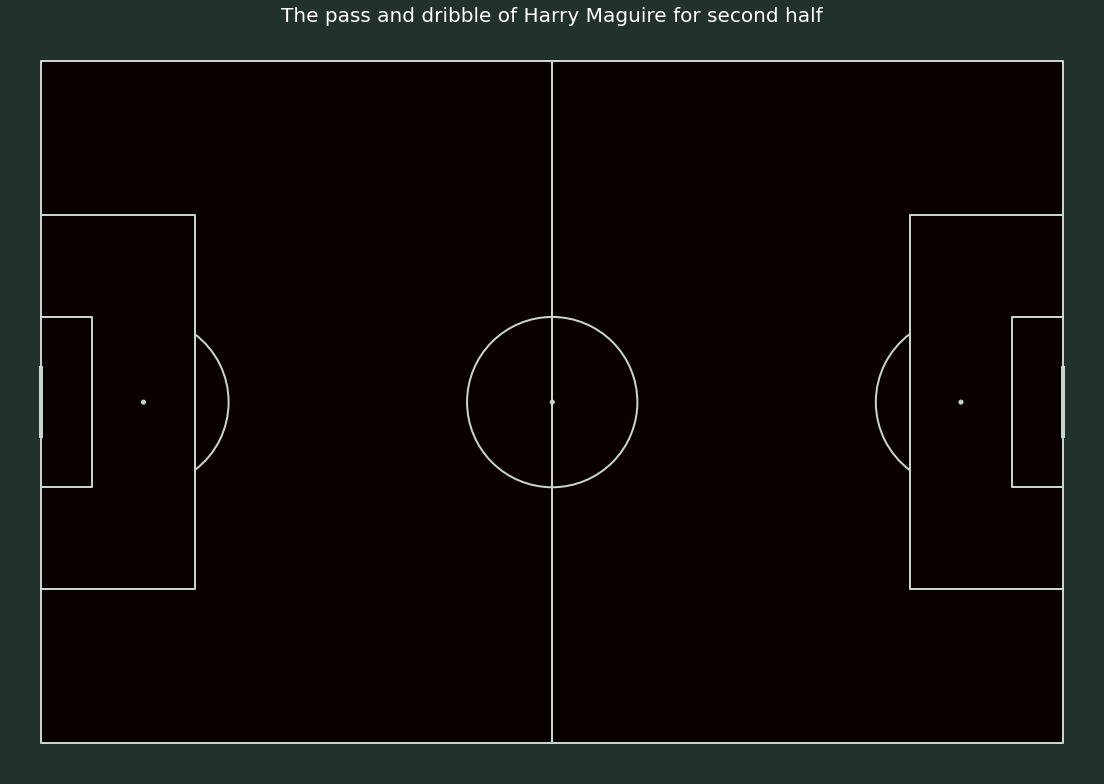

In [11]:
player = "Harry Maguire"
pitch.passmap(df, player=player, time_start=0, time_ends=90)
pitch.playerheatmap(df, player=player, time_start=0, time_ends=90)
pitch.playerheatmap(df, player=player, time_start=0, time_ends=45)
pitch.playerheatmap(df, player=player, time_start=45, time_ends=90)